In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from collections import Counter
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, \
train_test_split, validation_curve
from xgboost.sklearn import XGBClassifier

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize':(15,7)}, style='whitegrid')
plt.rcParams['figure.figsize'] = (15,7)

In [2]:
DATA_PATH = 'data/'

TRAIN_FEATURES = os.path.join(DATA_PATH, 'train_new_features.csv')

In [3]:
train_df = pd.read_csv(TRAIN_FEATURES, index_col=0, encoding='utf-8')

In [4]:
train_df.head(2)

,text,target,text_cleaned,preprocessed_text,sentence_count,word_count,stop_word_count,stop_word_share,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,polarity_raw,subjectivity_raw,unique_word_count,unique_word_share,polarity,subjectivity,DT,NN,PRP$,NNS,VBP,IN,MD,VB,JJ,PRP,JJS,VBN,VBD,TO,VBG,CC,RB,EX,VBZ,CD,WP,RP,JJR,WRB,FW,WDT,NNP,RBR,RBS,PDT,SYM,UH,WP$
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,our deeds are the reason of this earthquake may allah forgive us all,deed reason earthquak may allah forgiv us,1,13,6,0.461538,0,4.384615,69,1,1,0,0.0,0.0,7,1.0,0.0,0.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la rong sask canada,1,7,0,0.000000,0,4.571429,38,1,0,0,0.1,0.4,7,1.0,0.1,0.4,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data preparation

In [5]:
if train_df.isnull().any().any():
    print('Found missing values in data')
else:
    print('No missing values in data')

Found missing values in data


In [6]:
train_df.fillna('', inplace = True)

In [7]:
train = train_df.drop(['text', 'text_cleaned', 'preprocessed_text', 'target'], axis=1)
y = train_df['target']
print("Number of columns in train set: {}".format(len(list(train))))

Number of columns in train set: 49


In [8]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=13, stratify=y)

In [9]:
X_train.shape, X_test.shape

((5264, 49), (2256, 49))

In [10]:
sc = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled.loc[:, list(X_train_scaled)] = sc.fit_transform(X_train_scaled[list(X_train_scaled)])

X_test_scaled = X_test.copy()
X_test_scaled.loc[:, list(X_test_scaled)] = sc.transform(X_test_scaled[list(X_test_scaled)])

## Dataset visualization

We use a singular value decomposition to reduce our dataset to two dimensions. This will allow us to see any inherent linear seperability in the data that our model could capitalize on.

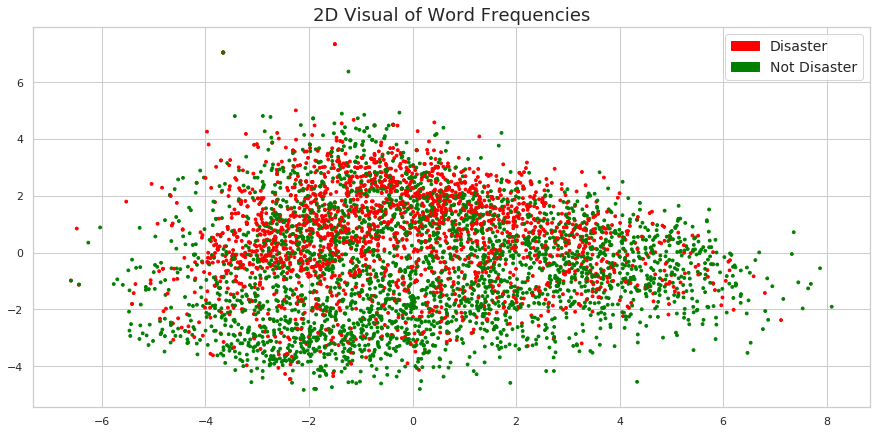

In [11]:
def plot_lsa(text, labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(text)
    lsa_scores = lsa.transform(text)
    color_dict = {label:idx for idx, label in enumerate(set(labels))}
    color_column = [color_dict[label] for label in labels]
    colors = ['green', 'red']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, c = labels, cmap = matplotlib.colors.ListedColormap(colors))
        green_patch = mpatches.Patch(color='green', label='Not Disaster')
        red_patch = mpatches.Patch(color='red', label='Disaster')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 14})
        
plot_lsa(X_train_scaled, y_train)
plt.title("2D Visual of Word Frequencies", size = 18)
plt.show()

### APPROACHES:
 - linear model (Logistic Regression),
 - boosting (XGBoost)

**Define evaluation procedure.**

We will use repeated cross-validation to evaluate the model, with 5-fold cross-validation.

In [12]:
kf = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)

**Define functions for reports with numbers and plots.**

```The leaderboard is based on Mean F-Score which can be implemented with Macro Average F1 Score.```

In [13]:
def plot_cv_with_err(model,
                     data_X,
                     data_y,
                     parameter_name, 
                     params,
                     cv_score,
                     **kwargs):
    
    """Plot results of cv_output_all"""
    
    val_train, val_test = validation_curve(model,
                                           data_X,
                                           data_y,
                                           param_name=parameter_name,
                                           param_range=params,
                                           cv=kf,
                                           scoring=cv_score)
    
    means_train = np.mean(val_train, axis=1)
    stds_train = np.std(val_train, axis=1)
    means_test = np.mean(val_test, axis=1)
    stds_test = np.std(val_test, axis=1)

    lines_train = plt.plot(params, means_train,
                           '-', label='CV training scores on train set', **kwargs)
    lines_test = plt.plot(params, means_test,
                          '-', label='CV validation scores on train set', **kwargs)
    
    plt.fill_between(params, means_train - stds_train, means_train + stds_train,
                     edgecolor='none', facecolor=lines_train[0].get_color(), alpha=0.2)
    plt.fill_between(params, means_test - stds_test, means_test + stds_test,
                     edgecolor='none', facecolor=lines_test[0].get_color(), alpha=0.2)

In [14]:
def cv_output_all(model,
                  data_X,
                  data_y,
                  parameter_name, 
                  params,
                  cv_score):
    
    """Same as plot_cv_with_err"""
    
    val_train, val_test = validation_curve(model,
                                           data_X,
                                           data_y,
                                           param_name=parameter_name,
                                           param_range=params,
                                           cv=kf,
                                           scoring=cv_score)
    means_train = np.mean(val_train, axis=1)
    stds_train = np.std(val_train, axis=1)
    means_test = np.mean(val_test, axis=1)
    stds_test = np.std(val_test, axis=1)
    
    print("                                    CV scores on Train set")
    print("================================================================================================")
    print("  mean_train_score (std_train_score) | mean_valid_score (std_valid_score) |      parameter")
    print("================================================================================================")
    for mean_tr, stdev_tr, mean_te, stdev_te, param \
            in zip(means_train, stds_train, means_test, stds_test, params):
        print("    {:^{width}.{prec}}  ({:^{width}.{prec}}) |   {:^{width}.{prec}}  ({:^{width}.{prec}}) | {:{align}} = {:{align}.{prec}}"
              .format(mean_tr, stdev_tr,
                      mean_te, stdev_te,
                      parameter_name, param,
                      align='<', width='14', prec=5))


## LOGISTIC REGRESSION 

**Define model.**

In [15]:
lr = LogisticRegression(solver='liblinear', penalty='l1', C=1e5,
                        class_weight='balanced', random_state=13)

In [16]:
lr.fit(X_train_scaled, y_train)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=13, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

**Evaluate model, establish a baseline.**

In [17]:
print("f1_score (train set): {:.5}".format(
            f1_score(y_train, lr.predict(X_train_scaled), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, lr.predict(X_test_scaled), average='macro')
))

f1_score (train set): 0.69018

f1_score (test set):  0.67269


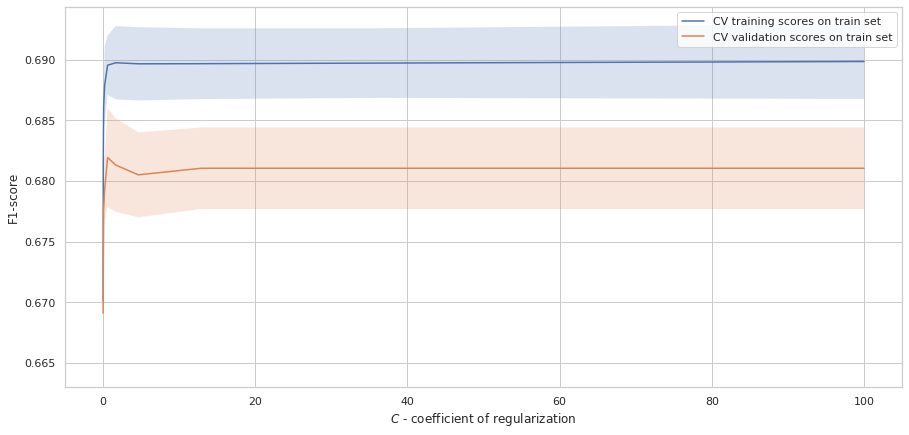

In [18]:
plot_cv_with_err(model = lr,
                 data_X = X_train_scaled,
                 data_y = y_train,
                 parameter_name = 'C', 
                 params = np.logspace(-2, 2, 10),
                 cv_score = 'f1_macro')

plt.xlabel("$C$ - coefficient of regularization")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.grid(True)

It seems possible that our data simply can't be fit by a logistic model.

**Feature importance of our model.**

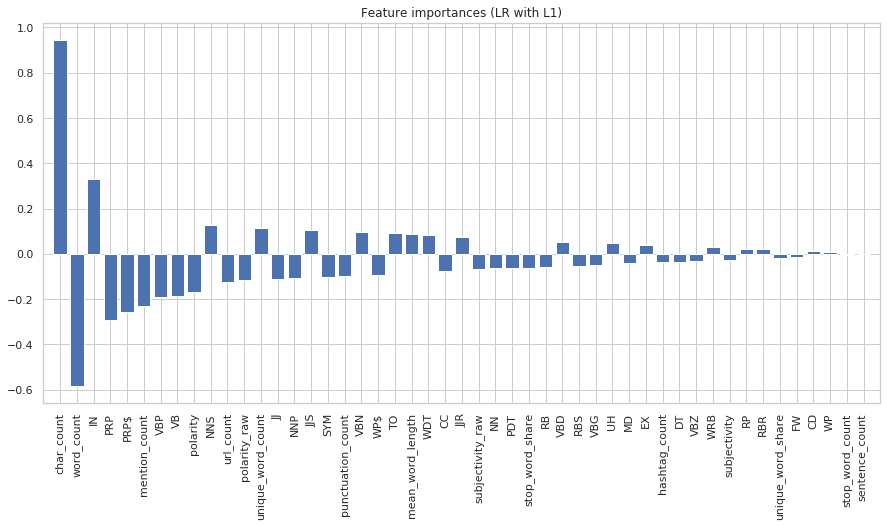

In [19]:
lr_features = LogisticRegression(solver='liblinear', penalty='l1', C=1,
                                 class_weight='balanced', random_state=13)
lr_features.fit(X_train_scaled, y_train)

importances = lr_features.coef_[0]
indices = np.argsort(np.abs(importances))[::-1]
plt.title("Feature importances (LR with L1)")
plt.bar(np.arange(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), X_train_scaled.columns[indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.show()

In [20]:
lr_1 = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=13)

lr_param_grid_1 = {'penalty': ['l1', 'l2'],
                   'C': np.logspace(-2, 2, 10)}

lr_clf_1 = GridSearchCV(estimator=lr_1, cv=kf, param_grid=lr_param_grid_1, scoring='f1_macro', verbose=1)

%time  lr_clf_1.fit(X_train_scaled, y_train)

print("\nBest_params: {}, best_score: {:.5}".format(lr_clf_1.best_params_, lr_clf_1.best_score_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.7s finished


CPU times: user 32.9 s, sys: 2.34 s, total: 35.3 s
Wall time: 21.4 s

Best_params: {'C': 0.5994842503189409, 'penalty': 'l1'}, best_score: 0.68193


In [21]:
lr_2 = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=13)

lr_param_grid_2 = {'penalty': ['l2'],
                   'C': np.linspace(0.001, 10, 40)}

lr_clf_2 = GridSearchCV(estimator=lr_2, cv=kf, param_grid=lr_param_grid_2, scoring='f1_macro', verbose=1)

%time  lr_clf_2.fit(X_train_scaled, y_train)

print("\nBest_params: {}, best_score: {:.5}".format(lr_clf_2.best_params_, lr_clf_2.best_score_))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 1min 2s, sys: 2.5 s, total: 1min 4s
Wall time: 32.6 s

Best_params: {'C': 0.7701538461538461, 'penalty': 'l2'}, best_score: 0.68149


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   32.4s finished


**Final model.**

In [22]:
lr_final = LogisticRegression(C=0.8, penalty='l2', solver='liblinear', class_weight='balanced', random_state=13)

%time lr_final.fit(X_train_scaled, y_train)

CPU times: user 176 ms, sys: 254 µs, total: 176 ms
Wall time: 176 ms


LogisticRegression(C=0.8, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=13, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

**Evaluate model.**

In [23]:
print("f1_score (train set): {:.5}".format(
            f1_score(y_train, lr_final.predict(X_train_scaled), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, lr_final.predict(X_test_scaled), average='macro')
))

f1_score (train set): 0.69077

f1_score (test set):  0.67222


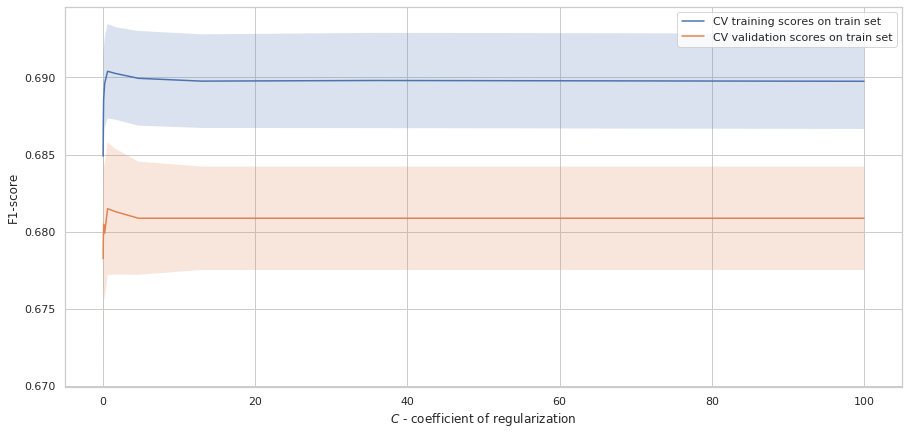

In [24]:
plot_cv_with_err(model = lr_final,
                 data_X = X_train_scaled,
                 data_y = y_train,
                 parameter_name = 'C', 
                 params = np.logspace(-2, 2, 10),
                 cv_score = 'f1_macro')

plt.xlabel("$C$ - coefficient of regularization")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.grid(True)

The trend is quite visible.

Training and validation errors differ significantly. This can be explained by **overfitting**. When there are too many parameters or regularization is not strict enough, the algorithm can be "distracted" by the noise in the data and lose track of the overall trend.

Our model tend to be overfitted.

In [25]:
cv_output_all(model = lr_final,
              data_X = X_train_scaled,
              data_y = y_train,
              parameter_name = 'C', 
              params = np.linspace(0.001, 5, 40),
              cv_score = 'f1_macro'
             )

                                    CV scores on Train set
  mean_train_score (std_train_score) | mean_valid_score (std_valid_score) |      parameter
        0.6763      (  0.0019172   ) |       0.6697      (   0.004288   ) | C = 0.001
       0.68924      (  0.0034757   ) |      0.68086      (  0.0046784   ) | C = 0.12918
       0.68976      (  0.0029582   ) |      0.68028      (  0.0044737   ) | C = 0.25736
       0.69016      (  0.0033843   ) |      0.68099      (  0.0052145   ) | C = 0.38554
       0.69022      (  0.0029857   ) |      0.68131      (  0.0043643   ) | C = 0.51372
       0.69045      (  0.0030565   ) |      0.68149      (  0.0043104   ) | C = 0.6419
        0.6903      (  0.0030391   ) |      0.68149      (  0.0039902   ) | C = 0.77008
        0.6902      (   0.002809   ) |      0.68149      (  0.0039902   ) | C = 0.89826
       0.68996      (   0.002742   ) |      0.68149      (  0.0039902   ) | C = 1.0264
       0.69006      (  0.0027128   ) |      0.68149      (  0.


## XGBoost Classifier

Before any modification or tuning is made to the XGBoost algorithm for imbalanced classification, it is important to test the default XGBoost model and **establish a baseline in performance**.

**Define model.**

In [26]:
xgb = XGBClassifier(objective='binary:logistic', booster='gbtree', random_state=13)

**Fit model (optimize model loss function).**

In [27]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=13, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Evaluate model, establish a baseline.**

In [28]:
print("f1_score (train set): {:.5}".format(
            f1_score(y_train, xgb.predict(X_train), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, xgb.predict(X_test), average='macro')
))

f1_score (train set): 0.94357

f1_score (test set):  0.68889


**Imbalanced Classification.**

The *scale_pos_weight* can be used to train a class-weighted or cost-sensitive version of XGBoost for imbalanced classification.

- #### scale_pos_weight = total_negative_examples / total_positive_examples

In [29]:
counter = Counter(y_train)
estimate = counter[0] / counter[1]
print('scale_pos_weight: %.3f' % estimate)

scale_pos_weight: 1.336


**Hyperparameter optimization.**

In [30]:
xgb_1 = XGBClassifier(scale_pos_weight=1.336, learning_rate=0.12,
                      max_depth=6, min_child_weight=42, gamma=0,
                      colsample_bytree=0.9, subsample=0.6,
                      reg_alpha=0.1, reg_lambda=1e-05,
                      objective='binary:logistic', booster='gbtree', random_state=13)

xgb_1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.12, max_delta_step=0, max_depth=6,
              min_child_weight=42, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=13, reg_alpha=0.1,
              reg_lambda=1e-05, scale_pos_weight=1.336, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
print("f1_score (train set): {:.5}".format(
            f1_score(y_train, xgb_1.predict(X_train), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, xgb_1.predict(X_test), average='macro')
))

f1_score (train set): 0.75616

f1_score (test set):  0.68447


**Early Stopping to Avoid Overfitting.**

It avoids overfitting by attempting to automatically select the inflection point where **performance on the test dataset starts to decrease** while **performance on the training dataset continues to improve** as the model starts to overfit.

In [32]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                            test_size=0.33, random_state=7)

xgb_2 = XGBClassifier(scale_pos_weight=1.336, learning_rate=0.12,
                      max_depth=6, min_child_weight=42, gamma=0,
                      colsample_bytree=0.9, subsample=0.6,
                      reg_alpha=0.1, reg_lambda=1e-05,
                      objective='binary:logistic', booster='gbtree', random_state=13)

eval_set = [(X_tr, y_tr), (X_val, y_val)]

xgb_2.fit(X_tr, y_tr, eval_metric=['error', 'logloss'], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.34203	validation_0-logloss:0.67680	validation_1-error:0.31991	validation_1-logloss:0.67572
[1]	validation_0-error:0.32019	validation_0-logloss:0.66386	validation_1-error:0.30667	validation_1-logloss:0.66207
[2]	validation_0-error:0.32473	validation_0-logloss:0.65290	validation_1-error:0.29689	validation_1-logloss:0.64914
[3]	validation_0-error:0.32757	validation_0-logloss:0.64401	validation_1-error:0.30437	validation_1-logloss:0.64017
[4]	validation_0-error:0.32445	validation_0-logloss:0.63632	validation_1-error:0.31128	validation_1-logloss:0.63264
[5]	validation_0-error:0.31480	validation_0-logloss:0.62768	validation_1-error:0.30034	validation_1-logloss:0.62449
[6]	validation_0-error:0.30885	validation_0-logloss:0.62173	validation_1-error:0.30322	validation_1-logloss:0.61898
[7]	validation_0-error:0.31197	validation_0-logloss:0.61635	validation_1-error:0.30034	validation_1-logloss:0.61327
[8]	validation_0-error:0.31168	validation_0-logloss:0.61227	validation_1

[71]	validation_0-error:0.26064	validation_0-logloss:0.52885	validation_1-error:0.28884	validation_1-logloss:0.56461
[72]	validation_0-error:0.25723	validation_0-logloss:0.52768	validation_1-error:0.28596	validation_1-logloss:0.56459
[73]	validation_0-error:0.25978	validation_0-logloss:0.52762	validation_1-error:0.28884	validation_1-logloss:0.56491
[74]	validation_0-error:0.25695	validation_0-logloss:0.52704	validation_1-error:0.28711	validation_1-logloss:0.56467
[75]	validation_0-error:0.25752	validation_0-logloss:0.52602	validation_1-error:0.28596	validation_1-logloss:0.56408
[76]	validation_0-error:0.25553	validation_0-logloss:0.52506	validation_1-error:0.28769	validation_1-logloss:0.56398
[77]	validation_0-error:0.25581	validation_0-logloss:0.52472	validation_1-error:0.28711	validation_1-logloss:0.56463
[78]	validation_0-error:0.25298	validation_0-logloss:0.52418	validation_1-error:0.28596	validation_1-logloss:0.56407
[79]	validation_0-error:0.24957	validation_0-logloss:0.52346	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.12, max_delta_step=0, max_depth=6,
              min_child_weight=42, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=13, reg_alpha=0.1,
              reg_lambda=1e-05, scale_pos_weight=1.336, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
print("f1_score (train set): {:.5}".format(
            f1_score(y_train, xgb_2.predict(X_train), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, xgb_2.predict(X_test), average='macro')
))

f1_score (train set): 0.73551

f1_score (test set):  0.68249


**Plot performance metrics.**

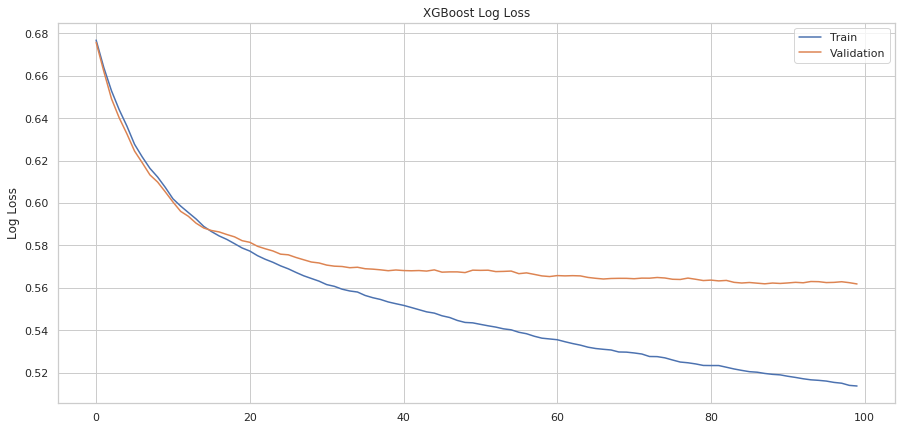

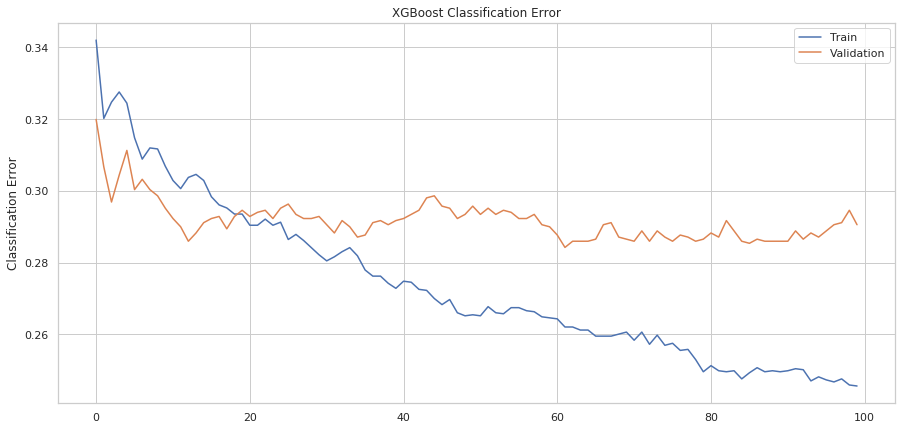

In [34]:
results = xgb_2.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Validation')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

The first plot shows the logarithmic loss of the XGBoost model for each epoch on the training and test datasets.

The second plot shows the classification error of the XGBoost model for each epoch on the training and test datasets.

From reviewing the logloss plot, it looks like there is an opportunity to stop the learning early, perhaps somewhere around epoch 80 to epoch 100.

We see a similar story for classification error, where error appears to go back up at around epoch 10.

### Final model.

In [35]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                            test_size=0.33, random_state=13)

xgb_final = XGBClassifier(scale_pos_weight=1.336, learning_rate=0.12,
                          max_depth=6, min_child_weight=42, gamma=0,
                          colsample_bytree=0.9, subsample=0.6,
                          reg_alpha=0.1, reg_lambda=1e-05,
                          objective='binary:logistic', booster='gbtree', random_state=13)

eval_set = [(X_val, y_val)]
xgb_final.fit(X_tr, y_tr, early_stopping_rounds=10, eval_metric='error', eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.35788
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.32566
[2]	validation_0-error:0.32163
[3]	validation_0-error:0.31991
[4]	validation_0-error:0.32394
[5]	validation_0-error:0.32336
[6]	validation_0-error:0.31933
[7]	validation_0-error:0.32624
[8]	validation_0-error:0.32394
[9]	validation_0-error:0.31818
[10]	validation_0-error:0.32163
[11]	validation_0-error:0.31991
[12]	validation_0-error:0.31358
[13]	validation_0-error:0.31300
[14]	validation_0-error:0.31358
[15]	validation_0-error:0.31646
[16]	validation_0-error:0.31300
[17]	validation_0-error:0.31415
[18]	validation_0-error:0.31415
[19]	validation_0-error:0.31358
[20]	validation_0-error:0.31588
[21]	validation_0-error:0.31070
[22]	validation_0-error:0.31185
[23]	validation_0-error:0.31013
[24]	validation_0-error:0.30955
[25]	validation_0-error:0.30783
[26]	validation_0-error:0.30667
[27]	validation_0-error:0.30783
[28]	validation_0-error:0.30552
[29]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.12, max_delta_step=0, max_depth=6,
              min_child_weight=42, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=13, reg_alpha=0.1,
              reg_lambda=1e-05, scale_pos_weight=1.336, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Evaluate model.**

In [36]:
print("f1_score (train set): {:.5}".format(
            f1_score(y_train, xgb_final.predict(X_train), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, xgb_final.predict(X_test), average='macro')
))

f1_score (train set): 0.71186

f1_score (test set):  0.68424


We can see that **the model stopped training at epoch 36** (close to what we expected by our manual judgment of learning curves) and that the model with **the best loss was observed at epoch 26**.

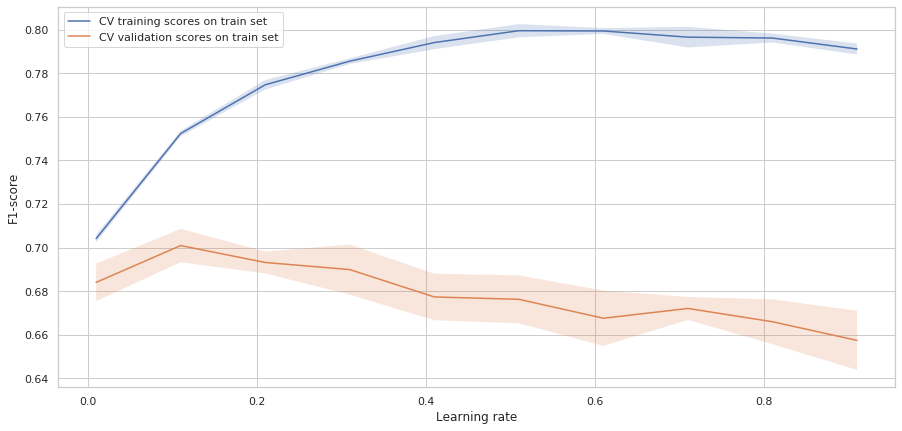

In [37]:
plot_cv_with_err(model = xgb_final,
                 data_X = X_train,
                 data_y = y_train,
                 parameter_name = 'learning_rate',
                 params = [i/100.0 for i in range(1,101,10)],
                 cv_score = 'f1_macro')

plt.xlabel("Learning rate")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.grid(True)

In [38]:
cv_output_all(model = xgb_final,
              data_X = X_train,
              data_y = y_train,
              parameter_name = 'learning_rate', 
              params = [i/100.0 for i in range(1,101,10)],
              cv_score = 'f1_macro'
             )

                                    CV scores on Train set
  mean_train_score (std_train_score) | mean_valid_score (std_valid_score) |      parameter
        0.7041      (  0.0017019   ) |      0.68401      (  0.0086095   ) | learning_rate = 0.01
       0.75236      (  0.0012629   ) |      0.70091      (   0.007657   ) | learning_rate = 0.11
       0.77475      (   0.002194   ) |      0.69315      (  0.0050365   ) | learning_rate = 0.21
        0.7856      (  0.0013074   ) |      0.68988      (    0.0115    ) | learning_rate = 0.31
       0.79413      (  0.0030159   ) |      0.67731      (   0.010684   ) | learning_rate = 0.41
       0.79958      (  0.0030457   ) |      0.67623      (   0.011016   ) | learning_rate = 0.51
       0.79946      (  0.0013436   ) |      0.66755      (   0.012678   ) | learning_rate = 0.61
       0.79662      (  0.0047443   ) |      0.67203      (  0.0052827   ) | learning_rate = 0.71
       0.79622      (  0.0020389   ) |      0.66593      (   0.010297   ) 

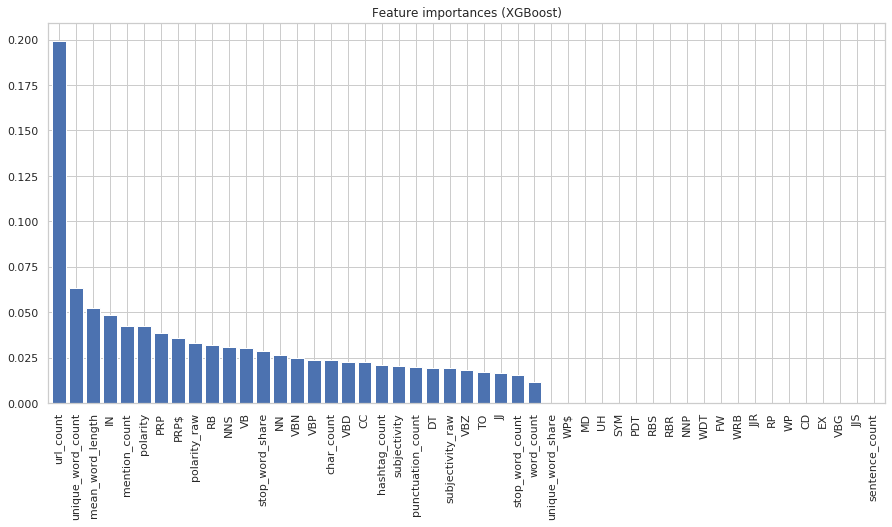

In [39]:
fi = pd.Series(xgb_final.feature_importances_, index=X_train.columns)
fi.sort_values(ascending=False).plot(kind='bar', width=0.8)
plt.title("Feature importances (XGBoost)")
plt.show()

It seems that feature extraction from tweets gave us at least one golden feature - url_count. It seems interpretable, because in not disaster tweets there are rarely links on internet pages. Also it could be because of greate part of disaster tweets are written by news agences.

## Results

In [40]:
def get_scores(estimator, X, y, name):
    y_pred = estimator.predict(X)
    y_pred_proba = estimator.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    columns = ['accuracy', 'precision', 'recall', 'F1-macro', 'AUC-ROC']
    results = pd.DataFrame([accuracy, precision, recall, f1, roc_auc], index=columns, columns=[name]).T

    return results

In [41]:
results_lr = get_scores(lr_final, X = X_test_scaled, y = y_test, name = 'LR')
results_xgb = get_scores(xgb_final, X = X_test, y = y_test, name = 'XGB')

In [42]:
results_lr.append(results_xgb)

,accuracy,precision,recall,F1-macro,AUC-ROC
LR,0.674645,0.605287,0.688083,0.672222,0.724727
XGB,0.688830,0.629048,0.664249,0.684240,0.738768


## Mispredicted tweets with XGBoost

**Predicted Neg/Actual Pos**

In [43]:
def find_fn(ypred, ytrue):
    y_fn  = X_test[(ypred==0)&(ypred!=ytrue)]
    return y_fn

y_pred_logr = xgb_final.predict(X_test)
fn = find_fn(y_pred_logr, y_test)
print('Number of False Negatives (Predicted Not Disaster/Actual Disaster): ', fn.shape, '\n') ;
train_df.loc[fn.index,:]

Number of False Negatives (Predicted Not Disaster/Actual Disaster):  (324, 49) 



,text,target,text_cleaned,preprocessed_text,sentence_count,word_count,stop_word_count,stop_word_share,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,polarity_raw,subjectivity_raw,unique_word_count,unique_word_share,polarity,subjectivity,DT,NN,PRP$,NNS,VBP,IN,MD,VB,JJ,PRP,JJS,VBN,VBD,TO,VBG,CC,RB,EX,VBZ,CD,WP,RP,JJR,WRB,FW,WDT,NNP,RBR,RBS,PDT,SYM,UH,WP$
4025,When ur friend and u are talking about forest fires in a forest and he tells u to drop ur mix tape out there... #straightfire,1,when ur friend and u are talking about forest fires in a forest and he tells u to drop ur mix tape out there straightfire,ur friend u talk forest fire forest tell u drop ur mix tape straightfir,1,25,10,0.400000,0,4.040000,125,4,1,0,0.000000,0.000000,11,0.785714,0.000000,0.000000,1.0,6.0,0.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1817,This guy bought my car on Tuesday police knocked my door yday cos he crashed n ran &amp; 2day he text me asking not to send the log book????????,1,this guy bought my car on tuesday police knocked my door yday cos he crashed n ran day he text me asking not to send the log book,guy bought car tuesday polic knock door yday cos crash n ran day text ask send log book,1,29,10,0.344828,0,4.000000,144,10,0,0,0.000000,0.000000,18,1.000000,0.000000,0.000000,2.0,7.0,2.0,0.0,0.0,1.0,0.0,1.0,3.0,3.0,0.0,0.0,4.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6199,Ready for this storm,1,ready for this storm,readi storm,1,4,2,0.500000,0,4.250000,20,0,0,0,0.200000,0.500000,2,1.000000,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5719,@aelinrhee a group of mascara smeared girls rioting will be horrific I think,1,a group of mascara smeared girls rioting will be horrific i think,group mascara smear girl riot horrif think,1,13,5,0.384615,0,4.923077,76,1,0,1,-1.000000,1.000000,7,1.000000,0.000000,0.000000,1.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6820,@lucysforsale funny cause my dumb ass was the young one to get n trouble the most lol,1,funny cause my dumb ass was the young one to get n trouble the most lol,funni caus dumb ass young one get n troubl lol,1,17,6,0.352941,0,4.058824,85,1,0,1,0.179167,0.550000,10,1.000000,0.175000,0.533333,2.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3281,@pantalonesfuego Yeah I grew up in the canyon above L.A. We had to evacuate a few times.,1,yeah i grew up in the canyon above l a we had to evacuate a few times,yeah grew canyon l evacu time,1,17,10,0.588235,0,4.235294,88,4,0,1,-0.100000,0.100000,6,1.000000,0.000000,0.000000,3.0,4.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1606,Why did I come to work today.. Literally wanna collapse of exhaustion,1,why did i come to work today literally want to collapse of exhaustion,come work today liter want collaps exhaust,1,12,5,0.416667,0,4.833333,69,2,0,0,0.000000,0.000000,7,1.000000,0.000000,0.000000,0.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,9 Mile backup on I-77 South...accident blocking the Right 2 Lanes at Exit 31 Langtree Rd...consider NC 115 or NC 150 to NC 16 as alternate,1,mile backup on i south accident blocking the right lanes at exit langtree rd consider nc or nc to nc as alternate,mile backup south accid block right lane exit langtre rd consid nc nc nc altern,1,26,6,0.230769,0,4.346154,138,7,0,0,0.142857,0.267857,13,0.866667,0.285714,0.535714,1.0,9.0,0.0,1.0,0.0,3.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

**Predicted Pos/ Actual Neg**

In [44]:
def find_fp(ypred, ytrue):
    y_fp  = X_test[(ypred==1)&(ypred!=ytrue)]
    return y_fp

fp = find_fp(y_pred_logr, y_test)
print('Number of False Positives (Predicted Disaster/Actual Not Disaster)): ', fp.shape, '\n') ;
train_df.loc[fp.index,:]

Number of False Positives (Predicted Disaster/Actual Not Disaster)):  (378, 49) 



,text,target,text_cleaned,preprocessed_text,sentence_count,word_count,stop_word_count,stop_word_share,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,polarity_raw,subjectivity_raw,unique_word_count,unique_word_share,polarity,subjectivity,DT,NN,PRP$,NNS,VBP,IN,MD,VB,JJ,PRP,JJS,VBN,VBD,TO,VBG,CC,RB,EX,VBZ,CD,WP,RP,JJR,WRB,FW,WDT,NNP,RBR,RBS,PDT,SYM,UH,WP$
256,The annihilation of Jeb Christie &amp; Kasich is less than 24 hours away..\nPlease God allow me at least one more full day...,0,the annihilation of jeb christie kasich is less than hours away please god allow me at least one more full day,annihil jeb christi kasich less hour away pleas god allow least one full day,2,23,7,0.304348,0,4.434783,124,7,0,0,0.095833,0.379167,14,1.000000,-0.038889,0.338889,1.0,5.0,0.0,1.0,1.0,4.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2661,Ignition Knock (Detonation) Sensor-Senso Standard KS161 http://t.co/WadPP69LwJ http://t.co/yjTh2nABv5,0,ignition knock detonation sensor senso standard ks,ignit knock deton sensor senso standard ks,1,8,0,0.000000,2,11.750000,101,13,0,0,0.000000,0.000000,7,1.000000,0.000000,0.000000,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2203,the fifth pre-dynastic #king in the legendary period before the #Deluge https://t.co/yr8knEpHGU #Dumuzid ''the Shepherd'',0,the fifth pre dynastic king in the legendary period before the deluge dumuzid the shepherd,fifth pre dynast king legendari period delug dumuzid shepherd,1,15,5,0.333333,1,7.133333,121,13,3,0,1.000000,1.000000,9,1.000000,0.000000,0.000000,4.0,5.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2786,The @rbcinsurance quote website = disaster. Tried 3 browsers &amp; 3 machines. Always get 'Missing Info' error due to a non-existant drop down.,0,the quote website disaster tried browsers machines always get missing info error due to a non existant drop down,quot websit disast tri browser machin alway get miss info error due non exist drop,1,23,3,0.130435,0,5.260870,143,10,0,1,-0.160185,0.237963,15,1.000000,-0.125000,0.375000,2.0,5.0,0.0,2.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3498,It's lights out again with stage-two load shedding: Stage-two load shedding will be in force between 5pm and 10pm. http://t.co/vxVfAEEY0q,0,it is lights out again with stage two load shedding stage two load shedding will be in force between pm and pm,light stage two load shed stage two load shed forc pm pm,1,20,9,0.450000,1,5.900000,137,10,0,0,0.000000,0.000000,7,0.583333,0.400000,0.700000,0.0,7.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1052,beforeitsnews : Global Derivatives: $1.5 Quadrillion Time Bomb http://t.co/GhmmUj7GbE (vÛ_ http://t.co/u9LvvLzhYe) http://t.co/LyJ57pq3yX,0,beforeitsnews global derivatives quadrillion time bomb v,beforeitsnew global deriv quadrillion time bomb v,1,12,0,0.000000,3,10.583333,138,22,0,0,0.000000,0.000000,7,1.000000,0.000000,0.000000,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
779,New post: Prysmian secures contract for Blight Bank wind farm http://t.co/oLG09Kb6HA,0,new post prysmian secures contract for blight bank wind farm,new post prysmian secur contract blight bank wind farm,1,11,1,0.090909,1,6.727273,84,6,0,0,0.136364,0.454545,9,1.000000,0.136364,0.454545,0.0,4.0,0.0,1.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2340,Doing Giveaway Music Kit Dren Death's Head Demolition: http://t.co/fHKhCqPl7j,0,doing giveaway music kit dren death s head demolition,giveaway music kit dre

## CONCLUSIONS

1. Logistic Regression and XGBoost machine learning models with tuned hyperparameters were applied to the tabular data.
2. It was shown that feature extraction from texts provided a golden feature - number of url adresses in a tweet.
3. In this approaches XGBoost proved to be the best.
4. Two different approaches were compared. Firstly, different machine learning models were applied to the TF-IDF matrix obtained from the preprocessed texts. Finally, the same machine learning methods (but with different hyperparameters) were applied to the tabular data. On tabular data XGBoost proved to be the best, but the best F1-score was acived with Logistic regression on TF-IDF data.